In [3]:
from __future__ import print_function
import os
import cv2
import h5py
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.patches as patches

### Functions

In [5]:
def gaussian2d(sup, scales):
    """
    Creates a 2D Gaussian based on the size and scale.
    """
    var   = scales * scales
    shape = (sup[0], sup[1])
    n,m   = [(i-1)/2 for i in shape]
    y,x   = np.ogrid[-m:m+1,-n:n+1]
    
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var))

    return g

In [23]:
def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    """
    e_x = np.exp(x - np.max(x))

    return e_x / e_x.sum(axis=0)

In [47]:
def generate_ground_gaussian_attention_mask(sample, sample_top, sample_height, sample_left, sample_width):
    """
    Creates a ground truth attention mask based on ground truth bounding boxes,
    and scales to fit into the box.
    """
    sample_image_height, sample_image_width, _ = sample.shape 
    scales = np.sqrt(2) * 8 # Play with the standard deviation
    
    # Convert even to odd by adding extra px
    if sample_width%2 == 0:
        sample_width += 1
    
    if sample_height%2 == 0:
        sample_height += 1
    
    gaussain = gaussian2d((sample_width, sample_height), scales)
    gaussain_normalized = (gaussain - np.min(gaussain))/\
                          (np.max(gaussain) - np.min(gaussain))

    sample_attention = np.zeros((sample_image_height, sample_image_width)) * 0.0
    
    sample_attention[sample_top:sample_top+sample_height, sample_left:sample_left+sample_width] = gaussain_normalized

    sample_attention_res  = cv2.resize(sample_attention, ground_attention_downsample, interpolation=cv2.INTER_NEAREST)

    sample_attention_res  = sample_attention_res.flatten()

    sample_attention_res_norm = softmax(sample_attention_res)
    sample_attention_res_norm = np.reshape(sample_attention_res_norm, ground_attention_downsample)

    return sample_attention, sample_attention_res_norm

In [44]:
def biggest_box(samples, total_samples):
    """
    Compute the box encompassing all the digits.
    """
    all_left  = []
    all_top   = []
    all_width = []
    all_heigt = []

    for k in range(total_samples):
        sample_label = samples[k][1]
        sample_left  = samples[k][2]
        sample_top   = samples[k][3]
        sample_width = samples[k][4]
        sample_heigt = samples[k][5]

        all_left.append(sample_left)
        all_top.append(sample_top)
        all_width.append(sample_left+sample_width)
        all_heigt.append(sample_top+sample_heigt)

    low_left = min(all_left)
    low_top  = min(all_top)
    highest_width = max(all_width) - low_left
    highest_height = max(all_heigt) - low_top

    return low_left, low_top, highest_width, highest_height

In [45]:
def generate_stop_attention_mask(samples, sample_image, total_samples):
    """
    Create an attention mask for the stop state, which is a
    uniform mask around the digits.
    """
    sample_image_height, sample_image_width, _ = sample_image.shape

    low_left, low_top, highest_width, highest_height = biggest_box(samples, total_samples)

    x = np.ones((sample_image_height, sample_image_width))

    mask = np.ones((sample_image_height, sample_image_width))
    mask[low_top:low_top+highest_height, low_left:low_left+highest_width] = 0

    x2 = np.multiply(x, mask)
    x3 = softmax(x2.flatten())
    x3 = np.reshape(x3, (sample_image_height, sample_image_width))

    return x3

### Main

In [6]:
#------------------------------------------------------------------------------
dataset_type     = 'test' # Change to train/test
dataset_dir      = './dataset'
curated_dataset  = os.path.join(dataset_dir, dataset_type + '_cropped')
curated_textfile = os.path.join(dataset_dir, dataset_type + '.txt')
file_path        = './dataset/%s/' % (dataset_type)
img_size         = (64, 64) # (width, height)
max_steps        = 5
ground_attention_downsample = (7, 7)

In [10]:
all_data = []

with open(curated_textfile, 'r') as f:
    frames = f.readlines()

for frame in frames:
    frame = frame.split(', ')
    iterm_data = []

    # Remove all non-interger characters
    for i in frame:
        i = i.replace("[", "")
        i = i.replace("[[", "")
        i = i.replace("]", "")
        i = i.replace("]]", "")
        i = i.replace("'", "")

        iterm_data.append(int(i))

    final_data = []

    count = 0
    for u in range(max_steps):
        each_data = []
        for k in range(6):
            if k == 0:
                each_data.append(str(iterm_data[count]) + '.png')
            else:
                each_data.append(iterm_data[count])

            count += 1

        final_data.append(each_data)
    
    all_data.append(final_data)

In [12]:
all_data[0]

[['1.png', 5, 13, 3, 22, 45],
 ['1.png', 0, 0, 0, 0, 0],
 ['1.png', 0, 0, 0, 0, 0],
 ['1.png', 0, 0, 0, 0, 0],
 ['1.png', 0, 0, 0, 0, 0]]

In [19]:
all_data[0][0][0]

'1.png'

### Visualize

In [9]:
## -- debug
# check how many samples:

In [16]:
sample_index = 501

In [20]:
sample_image_path = curated_dataset + '/' + all_data[sample_index][0][0]
print('Path:', sample_image_path)

Path: ./dataset/test_cropped/502.png


In [21]:
sample_image = cv2.imread(sample_image_path)

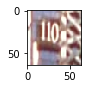

In [27]:
plt.figure(figsize=(1,1))
plt.imshow(sample_image)
plt.show()

In [135]:
sample_heigt_org, sample_width_org, _ = sample_image.shape

In [136]:
total_samples = np.array(all_data[sample_index][1]).shape[1]
print(np.array(all_data[j][1]).shape)

(5, 2)


In [29]:
all_data[sample_index][0]

['502.png', 1, 14, 9, 7, 26]

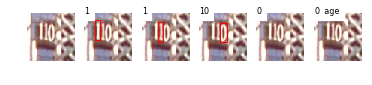

In [33]:
fig,ax = plt.subplots(1, max_steps+1)
plt.text(0, 1, 'image', color='black', backgroundcolor='white', fontsize=8)
ax[0].imshow(sample_image)
ax[0].axis('off')
        
for k in range(max_steps):
    sample_left  = abs(int(all_data[sample_index][k][2]))
    sample_top   = abs(int(all_data[sample_index][k][3]))
    sample_width = abs(int(all_data[sample_index][k][4]))
    sample_heigt = abs(int(all_data[sample_index][k][5]))
    sample_label = all_data[sample_index][k][1]
    
    rect = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,\
                             linewidth=1, edgecolor='r', facecolor='none')  
    ax[k+1].text(0, 1, sample_label, color='black', backgroundcolor='white', fontsize=8)
    ax[k+1].imshow(sample_image)
    ax[k+1].add_patch(rect)
    ax[k+1].axis('off')

### Generate attention mask

In [39]:
def samples_total(samples):
    total_samples= 0
    for k in range(max_steps):
        sample_label = samples[k][1]
        
        if int(sample_label) != 0:
            total_samples += 1
        
    return total_samples

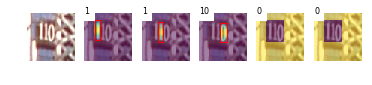

In [50]:
fig,ax = plt.subplots(1, max_steps+1)
#plt.text(0, 1, 'image', color='black', backgroundcolor='white', fontsize=8)
ax[0].imshow(sample_image)
ax[0].axis('off')
        
for k in range(max_steps):
    sample_left  = abs(int(all_data[sample_index][k][2]))
    sample_top   = abs(int(all_data[sample_index][k][3]))
    sample_width = abs(int(all_data[sample_index][k][4]))
    sample_heigt = abs(int(all_data[sample_index][k][5]))
    sample_label = all_data[sample_index][k][1]
    total_samples = samples_total(samples=all_data[sample_index])
    if int(sample_label) == 0:
        stop_mask = generate_stop_attention_mask(all_data[sample_index], sample_image, total_samples)
        ax[k+1].text(0, 1, sample_label, color='black', backgroundcolor='white', fontsize=8)
        ax[k+1].imshow(sample_image)        
        ax[k+1].imshow(stop_mask, alpha=0.5)
        ax[k+1].axis('off')
    else:
        acc, get_attention_mask = generate_ground_gaussian_attention_mask(sample_image,\
                                        sample_top, sample_heigt, sample_left, sample_width)
        rect = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,\
                                  linewidth=1, edgecolor='r', facecolor='none')  
        ax[k+1].text(0, 1, sample_label, color='black', backgroundcolor='white', fontsize=8)
        ax[k+1].imshow(sample_image)
        ax[k+1].imshow(acc, alpha=0.5)
        ax[k+1].add_patch(rect)
        ax[k+1].axis('off')